In [68]:
import lightgbm as lgb
import numpy as np
import optuna
import sklearn.datasets
import sklearn.metrics
from optuna.visualization import (
    plot_contour,
    plot_edf,
    plot_intermediate_values,
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
    plot_slice,
)
from sklearn.model_selection import train_test_split

SEED = 42

np.random.seed(SEED)

In [ ]:
params = {'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
              'max_depth': trial.suggest_int('max_depth', 1, 30),
              'num_leaves': trial.suggest_int('num_leaves', 2, 100),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
              'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
              'subsample': trial.suggest_uniform('subsample', 0.1, 1.0)}

In [ ]:
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    return train_evaluate


# Optuna

In [17]:
def objective(trial):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(
        param,
        dtrain,
        valid_sets=[dvalid],
        verbose_eval=False,
        callbacks=[pruning_callback],
    )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [18]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=10, timeout=600)

[I 2021-09-03 10:36:02,789] A new study created in memory with name: no-name-63c10c2b-ed83-40cc-abbb-bda8530922cf
[I 2021-09-03 10:36:02,891] Trial 0 finished with value: 0.965034965034965 and parameters: {'bagging_fraction': 0.6247240713084175, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 0 with value: 0.965034965034965.
[I 2021-09-03 10:36:02,985] Trial 1 finished with value: 0.986013986013986 and parameters: {'bagging_fraction': 0.759195090518222, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 1 with value: 0.986013986013986.
[I 2021-09-03 10:36:03,040] Trial 2 finished with value: 0.972027972027972 and parameters: {'bagging_fraction': 0.4348501673009197, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 1 with value: 0.986013986013986.
[I 2021-09-03 10:36:03,194] Trial 3 finished with value: 0.965034965034965 and parameters: {'bagging_fraction': 0.8248435466776274, 'bagging_freq': 1, 'min_child_samples': 98}. Best is trial 1 with value: 0.98601398

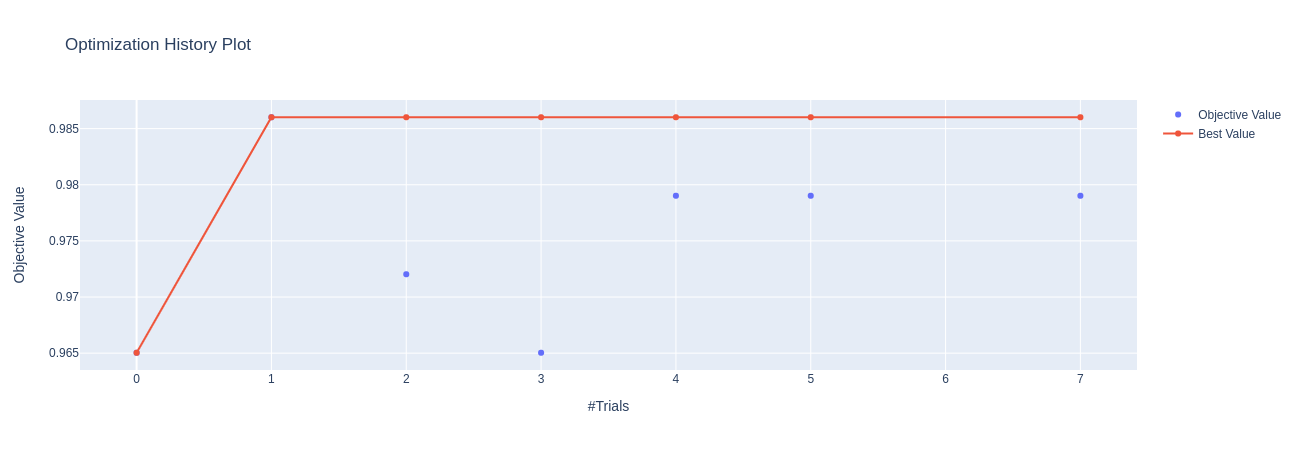

In [19]:
plot_optimization_history(study)

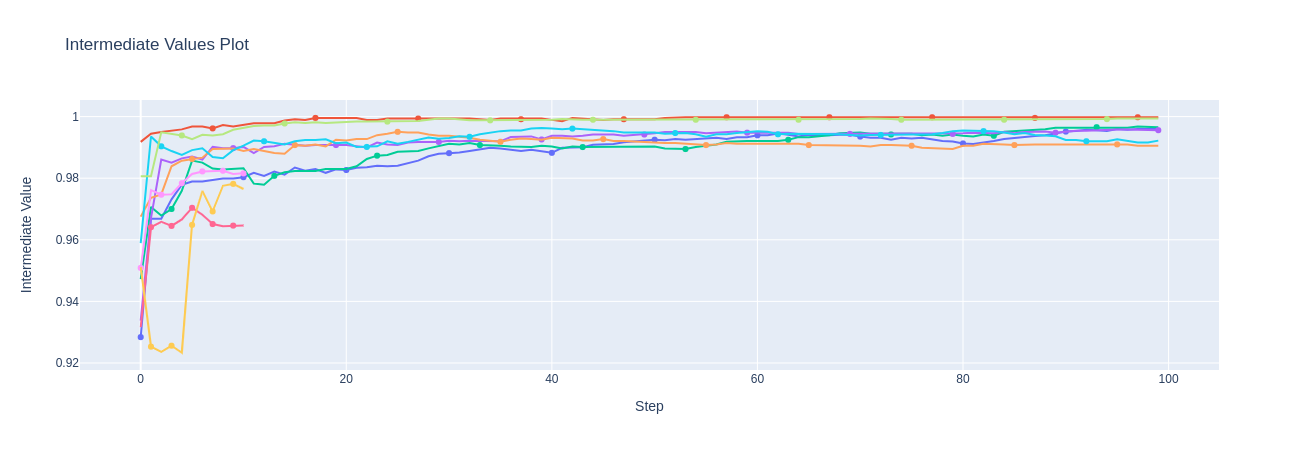

In [20]:
plot_intermediate_values(study)

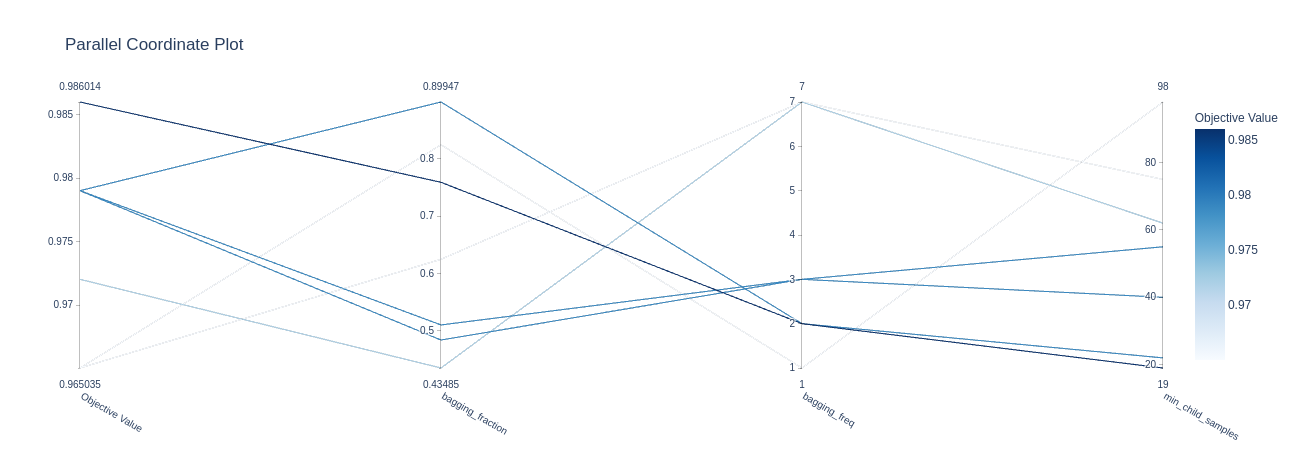

In [21]:
plot_parallel_coordinate(study)

In [22]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_min_child_samples,state
0,0,0.965035,2021-09-03 10:36:02.792506,2021-09-03 10:36:02.890864,0 days 00:00:00.098358,0.624724,7,75,COMPLETE
1,1,0.986014,2021-09-03 10:36:02.894830,2021-09-03 10:36:02.984609,0 days 00:00:00.089779,0.759195,2,19,COMPLETE
2,2,0.972028,2021-09-03 10:36:02.987615,2021-09-03 10:36:03.040276,0 days 00:00:00.052661,0.434850,7,62,COMPLETE
3,3,0.965035,2021-09-03 10:36:03.045852,2021-09-03 10:36:03.193914,0 days 00:00:00.148062,0.824844,1,98,COMPLETE
4,4,0.979021,2021-09-03 10:36:03.199346,2021-09-03 10:36:03.292661,0 days 00:00:00.093315,0.899466,2,22,COMPLETE
5,5,0.979021,2021-09-03 10:36:03.308530,2021-09-03 10:36:03.368787,0 days 00:00:00.060257,0.510043,3,55,COMPLETE
6,6,0.964604,2021-09-03 10:36:03.369946,2021-09-03 10:36:03.391200,0 days 00:00:00.021254,0.659167,3,63,PRUNED
7,7,0.979021,2021-09-03 10:36:03.392100,2021-09-03 10:36:03.472029,0 days 00:00:00.079929,0.483696,3,40,COMPLETE
8,8,0.981564,2021-09-03 10:36:03.473239,2021-09-03 10:36:03.497015,0 days 00:00:00.023776,0.673642,6,24,PRUNED
9,9,0.976488,2021-09-03 10:36:03.497892,2021-09-03 10:36:03.531022,0 days 00:00:00.033130,0.708541,5,9,PRUNED


# Hyperopt

In [55]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import pandas as pd

def hyperopt_train_evaluate(params):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)
    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        verbose_eval=False
    )

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy

In [56]:
space = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "bagging_fraction": hp.uniform("bagging_fraction", 0.4, 1.0),
    "bagging_freq": hp.choice("bagging_freq", range(1, 7)),
    "min_child_samples": hp.choice("min_child_samples", range(5, 100)),
}

In [65]:
def f(params):
    acc = hyperopt_train_evaluate(params)
    return {'loss': -acc, 'status': STATUS_OK} | params


trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)

100%|██████████| 10/10 [00:00<00:00, 14.82trial/s, best loss: -0.993006993006993]


In [73]:
df = pd.DataFrame(trials.results)

In [74]:
df = df.reset_index()
df.rename(columns={'index': 'id'}, inplace=True)

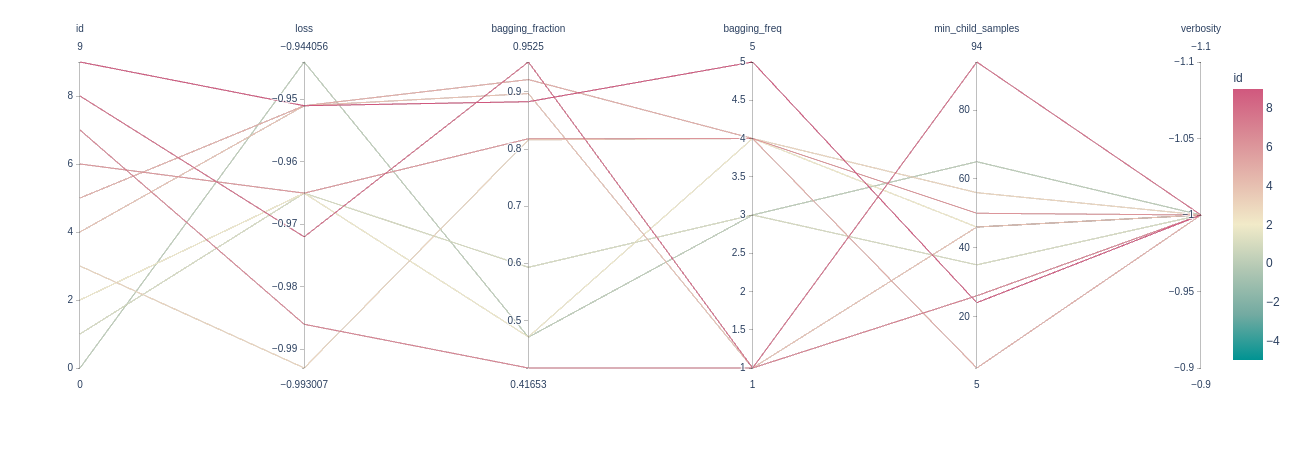

In [78]:
import plotly.express as px
fig = px.parallel_coordinates(df, color="id",
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()